# Clustering based on chrom5k CGN

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

from ALLCools.clustering import \
    tsne, \
    significant_pc_test, \
    filter_regions, \
    remove_black_list_region, \
    lsi, \
    binarize_matrix
from ALLCools.clustering.lsi import tf_idf
from ALLCools.plot import *
from ALLCools.mcds import MCDS

In [2]:
import os
os.chdir("/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/snm3c/hh_micro_mono/DMR_classifier/")

In [3]:
metadata_path = "allc_meta.tsv"
mcds_path = "DMR_5k.mcds/"
chunks = {"cell": 100, "mc_type": 1, "count_type": 1}

# PC cutoff
pc_cutoff = 0.1
resolution = 1

# Raw data

In [4]:
metadata = pd.read_csv(metadata_path, index_col=0, sep="\t")
print(f"Metadata of {metadata.shape[0]} cells")

Metadata of 29996 cells


In [5]:
metadata["celltype"].unique()

array(['Oligo', 'Astro', 'VIP', 'CA', 'NR2F2-LAMP5', 'Micro2', 'Micro1',
       'OPC', 'SUB', 'PVALB', 'SST', 'Endo-VLMC', 'DG', 'Marc_HT',
       'Fibro_Mus', 'Mono1', 'Marc_Nrv', 'Tnaive_CD4_1', 'NK_CD16_Bld',
       'Mac_Alv', 'Tnaive_CD4_2', 'NK_CK56_Skn', 'Mono2', 'Mono_HT',
       'Endo_Lym_Skn', 'Mast_Skn', 'Tnaive_CD8_1', 'NK_CD56_Bld',
       'Tnaive_CD8_2', 'infant_MGC-1'], dtype=object)

In [6]:
metadata["assay"] = "hh"
assay_ct = ["infant_MGC-1"]
metadata.loc[metadata["celltype"].isin(assay_ct), "assay"] = "Developing_Brain"
assay_ct = [
    "Marc_HT", "Fibra_Mus", "Marc_Nrv", "Tnaive_CD4_1", "NK_CD16_Bld", "Mac_Alv",
    "Tnaive_CD4_2", "NK_CK56_Skn", "Mono1", "Mono2", "Mono_HT", "Endo_Lym_Skn",
    "Mast_Skn", "Tnaive_CD8_1", "NK_CD56_Bld", "Tnaive_CD8_2"
]
metadata.loc[metadata["celltype"].isin(assay_ct), "assay"] = "Human_Atlas"

In [7]:
mcds = MCDS.open(mcds_path, var_dim="chrom5k", chunks=chunks)
mcds.add_cell_metadata(metadata)

In [8]:
mcds

<xarray.MCDS>
Dimensions:                    (cell: 29996, chrom5k: 642098, count_type: 2,
                                mc_type: 2)
Coordinates:
  * cell                       (cell) object 'hc1153-1-2-D12-AD002' ... 'allc...
  * chrom5k                    (chrom5k) <U27 'chr1_0' ... 'chrY_KI270740v1_r...
    chrom5k_chrom              (chrom5k) <U23 dask.array<chunksize=(642098,), meta=np.ndarray>
    chrom5k_end                (chrom5k) int64 dask.array<chunksize=(642098,), meta=np.ndarray>
    chrom5k_start              (chrom5k) int64 dask.array<chunksize=(642098,), meta=np.ndarray>
  * count_type                 (count_type) <U3 'mc' 'cov'
  * mc_type                    (mc_type) <U3 'CGN' 'CHN'
    cell_allc_path             (cell) object '/tscc/projects/ps-epigen/users/...
    cell_celltype              (cell) object 'Oligo' 'Astro' ... 'infant_MGC-1'
    cell_total_cov             (cell) int64 72792 78094 79141 ... 122640 324434
    cell_assay                 (cell) object 'hh' 'hh' ... 'Developing_Brain'
Data variables:
    chrom5k_da                 (cell, chrom5k, mc_type, count_type) uint32 dask.array<chunksize=(100, 642098, 1, 1), meta=np.ndarray>
    chrom5k_da_CGN-hypo-score  (cell, chrom5k) float16 dask.array<chunksize=(100, 642098), meta=np.ndarray>
    chrom5k_da_CHN-hypo-score  (cell, chrom5k) float16 dask.array<chunksize=(100, 642098), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom5k

In [9]:
# blacklist
black_list_path = "/tscc/projects/ps-epigen/users/biy022/scmethylhic/genome/genome_hg38/hg38_blacklist.v2.bed.gz"
black_list_fraction = 0.2
mcds = mcds.remove_black_list_region(black_list_path=black_list_path)

45816 chrom5k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


In [10]:
chrom_to_remove = ["chrX", "chrY", "chrM", "chrL"]
mcds = mcds.remove_chromosome(chrom_to_remove)

34491 chrom5k features in ['chrX', 'chrY', 'chrM', 'chrL'] removed.


In [11]:
mcad = mcds.get_score_adata(mc_type="CGN", quant_type="hypo-score")

Loading chunk 0-29996/29996


In [12]:
mcad.write_h5ad("chrom5k-ct_all-hypo_score-raw.h5ad")

## Preprocess the data

In [4]:
mcad = sc.read_h5ad("chrom5k-ct_all-hypo_score-raw.h5ad")

In [5]:
included_ct = [
    "CA", "DG", "SUB", "PVALB", "SST", "VIP", "NR2F2-LAMP5",
    "Astro", "Oligo", "OPC", "Endo-VLMC", "Micro1", "Micro2",
    "Endo_Lym_Skn", "Fibro_Mus", "Mast_Skn", "Mono2",
    "NK_CD16_Bld", "Tnaive_CD4_1", "infant_MGC-1"
]
mcad = mcad[mcad.obs["celltype"].isin(included_ct)].copy()

In [6]:
binarize_matrix(mcad, cutoff=0.95)

In [7]:
filter_regions(mcad)

192951 regions remained.


## LSI decomposition

In [8]:
svd = lsi(mcad, algorithm="arpack", obsm="X_pca")
n_components = significant_pc_test(mcad, p_cutoff=pc_cutoff, update=True)

43 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (25011, 100) to (25011, 43)


In [9]:
sc.pp.neighbors(mcad, use_rep="X_pca")
sc.tl.leiden(mcad, resolution=resolution)

In [10]:
try:
    sc.tl.paga(mcad, groups="leiden")
    sc.pl.paga(mcad, plot=False)
    sc.tl.umap(mcad, init_pos="paga")
except:
    sc.tl.umap(mcad)

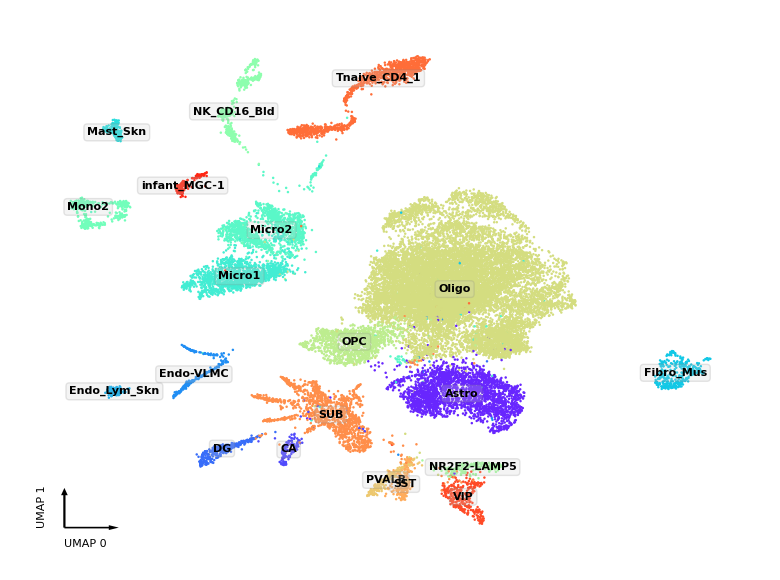

In [12]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
_ = categorical_scatter(
    data=mcad, 
    ax=ax, 
    coord_base="umap", 
    hue="celltype", 
    text_anno="celltype",
    show_legend=False
)
plt.tight_layout()

In [13]:
mcad.write_h5ad("chrom5k-ct_subset-hypo_score-binarized.h5ad")

In [14]:
mcad

AnnData object with n_obs × n_vars = 25011 × 192951
    obs: 'allc_path', 'celltype', 'total_cov', 'assay', 'leiden'
    var: 'chrom', 'end', 'start'
    uns: 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [16]:
from harmonypy import run_harmony

In [17]:
ho = run_harmony(
    mcad.obsm["X_pca"],
    meta_data=mcad.obs,
    vars_use="assay",
    random_state=0,
    nclust=100,
    max_iter_harmony=20,
    theta=1,
    lamb=2
)
mcad.obsm["X_harmony"] = ho.Z_corr.T

2025-10-15 17:22:39,091 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-15 17:22:44,622 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-15 17:22:44,706 - harmonypy - INFO - Iteration 1 of 20
2025-10-15 17:22:48,293 - harmonypy - INFO - Iteration 2 of 20
2025-10-15 17:22:52,018 - harmonypy - INFO - Converged after 2 iterations


In [18]:
sc.pp.neighbors(mcad, use_rep="X_harmony")
sc.tl.leiden(mcad, resolution=resolution)
try:
    sc.tl.paga(mcad, groups="leiden")
    sc.pl.paga(mcad, plot=False)
    sc.tl.umap(mcad, init_pos="paga")
except:
    sc.tl.umap(mcad)

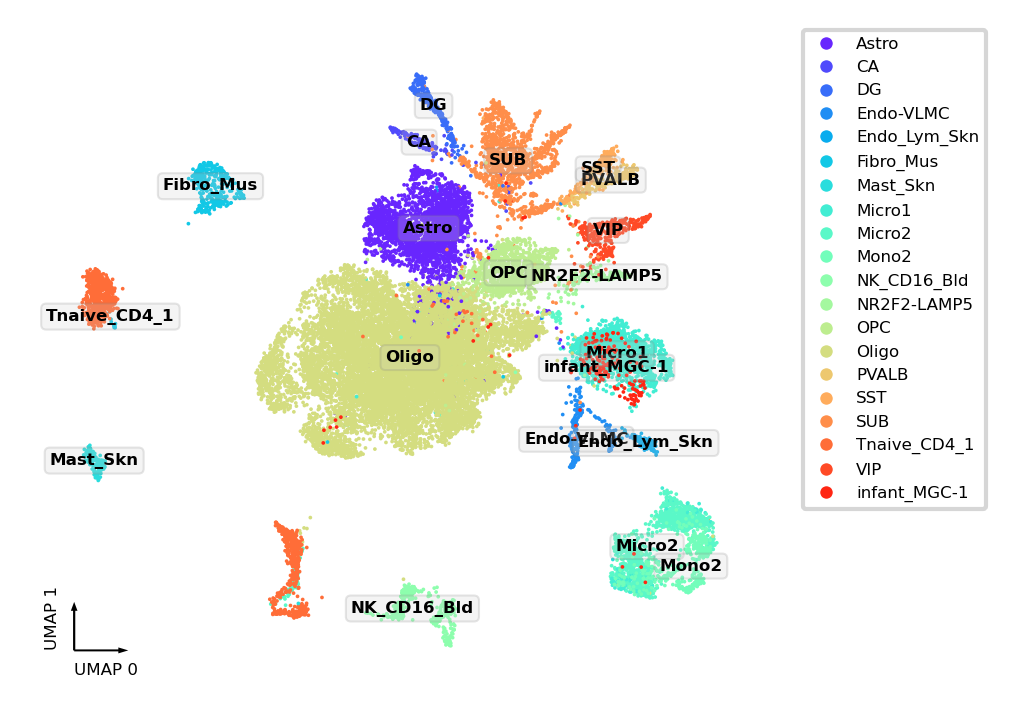

In [30]:
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300)
_ = categorical_scatter(
    data=mcad, 
    ax=ax, 
    coord_base="umap", 
    hue="celltype", 
    text_anno="celltype",
    show_legend=True,
    rasterized=False
)
plt.tight_layout()
plt.savefig("results/chrom5k-hypo_score_binarized-harmony.pdf", dpi=300, format="pdf")

In [26]:
mcad.write_h5ad("chrom5k-ct_subset-hypo_score-binarized.h5ad")